<a href="https://colab.research.google.com/github/eapzz/Crypt/blob/main/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data = tfds.load('fashion_mnist', split ='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVEE8QO/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVEE8QO/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
import os

if not os.path.exists("images"):
    os.makedirs("images")

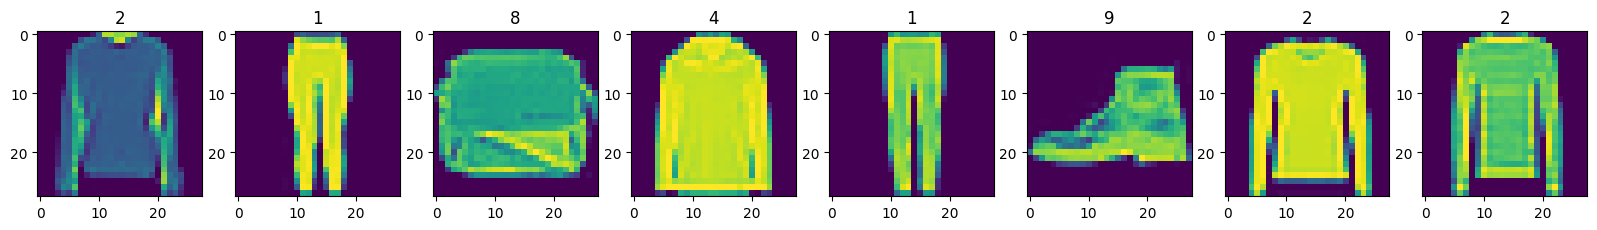

In [4]:
dataiterator = data.as_numpy_iterator()

# Visualization of dataset
fig, ax = plt.subplots(ncols=8, figsize=(20, 20))
for idx in range(8):
    # extracting image and subplotting
    sample = dataiterator.next()
    image = np.squeeze(sample['image'])
    label = sample['label']
    ax[idx].imshow(image)
    ax[idx].title.set_text(label)

In [5]:
def scale_images(data):
    image = data['image']
    return image / 255 #scaling


In [6]:
data = data.map(scale_images) #scaling applied
data = data.cache() #caching foer faster processing
data = data.shuffle(60000) #adding randomness
data = data.batch(128) #batch size = 128
data = data.prefetch(64) #performance enhancement


In [7]:
data.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D)

In [9]:
def build_generator():
    model = Sequential()

    model.add(Dense(7 * 7 * 128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

# Convolutional blocks

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

generator = build_generator()
generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [10]:
def build_discriminator():
    model = Sequential()

#Conv blocks

    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

g_opt = Adam(learning_rate=0.0001)  #Generator optimizer
d_opt = Adam(learning_rate=0.00001)  #Discriminator optimizer

g_loss = BinaryCrossentropy()  #Generator loss function
d_loss = BinaryCrossentropy()  #Discriminator loss function

In [12]:
from tensorflow.keras.models import Model

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs) # compiling with parent class
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, train1):
        real_images = train1
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False) #fake image generation using randng random noise


        with tf.GradientTape() as d_tape: #training distributor
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0) #labels for both real and fake

            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real)) # adding noise to make realistic and robust
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake) #total loss of discriminator

        #backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


        with tf.GradientTape() as g_tape: #generator training
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)#gererating new images
            predicted_labels = self.discriminator(gen_images, training=False) # values must be close to one since they are generated images
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) #generator loss

        # applying backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

fashgan = FashionGAN(generator, discriminator) #fashiongan instance
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [13]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1)) #vectors created as an input
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy() # fake images are generated
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [14]:
# Training the model
hist = fashgan.fit(data, epochs=100, callbacks=[ModelMonitor()])

Epoch 1/100
469/469 [==============================] - 98s 166ms/step - d_loss: 0.5560 - g_loss: 1.0964
Epoch 2/100
469/469 [==============================] - 78s 166ms/step - d_loss: 0.4625 - g_loss: 1.6333
Epoch 3/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6782 - g_loss: 0.6592
Epoch 4/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6832 - g_loss: 0.5879
Epoch 5/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6069 - g_loss: 0.9744
Epoch 6/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6800 - g_loss: 0.7397
Epoch 7/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6850 - g_loss: 0.6353
Epoch 8/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6839 - g_loss: 0.6153
Epoch 9/100
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6909 - g_loss: 0.6255
Epoch 10/100
469/469 [==============================] - 77s 165m

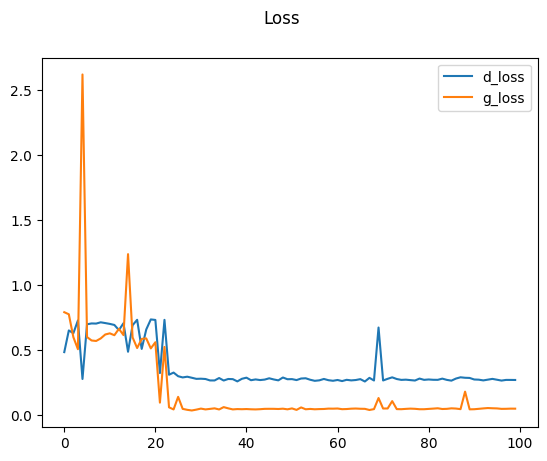

In [15]:
import matplotlib.pyplot as plt

# Plot the discriminator and generator losses
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [16]:
# To avoid the axes dont match arraty error by ensuring the model architecture matches the shape of the weights
from keras.models import Model

def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

model_freezed = freeze_layers(generator)
model_freezed.save("/content/generatormodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
generator.load_weights("/content/generatormodel.h5")


1/1 [==============================] - 0s 465ms/step


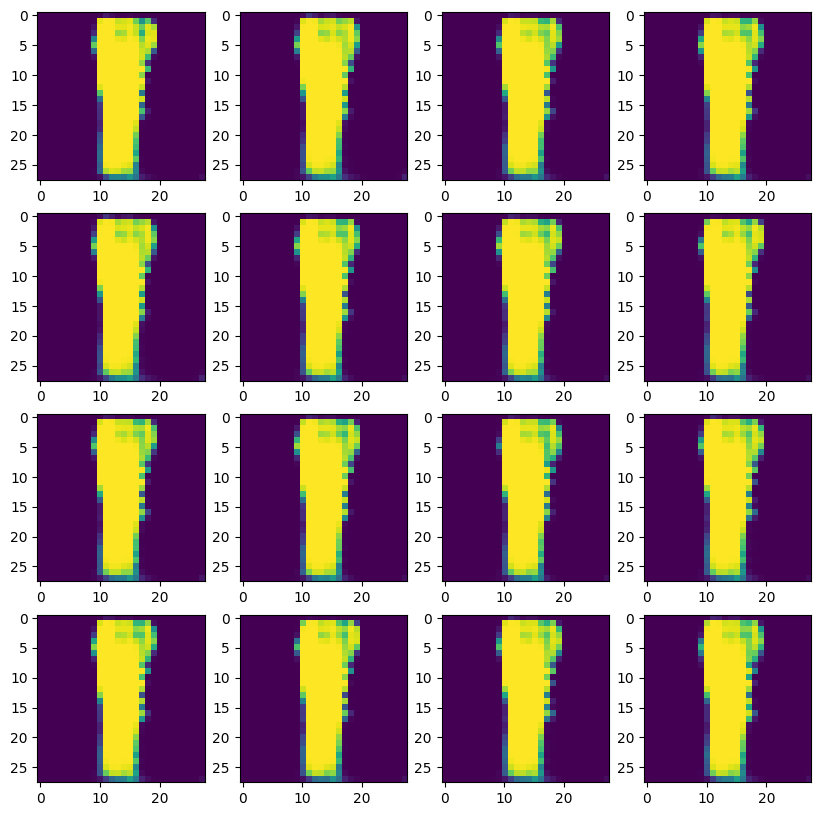

In [18]:
# Generate new fashion images
imgs = generator.predict(tf.random.normal((16, 128, 1)))

# Plot the generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r + 1) * (c + 1) - 1])